In [1]:
import pandas as pd
from sklearn.utils import shuffle

In [2]:
# this function processes columns of interest into a document to feed into the classifier

def process_dataframe(dataframe):
    docs = []
    for index, row in dataframe.iterrows():
        elements_of_row = [element for element in row if not pd.isnull(element)]
        docs.append('\n'.join(str(element) for element in elements_of_row))
        docs = list(set(docs))
    return docs

industries = ['accounting',
              'architecture_and_physical_engineering',
              'arts',
              'construction_and_manufacturing',
              'consumer',
              'consumer_products_and_goods',
              'education',
              'environment',
              'facilities_and_services',
              'film_animation_design_and_graphic_arts',
              'financial_services',
              'food',
              'health_wellness_and_fitness',
              'hospitality',
              'human_resources_and_recruiting',
              'international_affairs',
              'law',
              'marketing_and_advertising',
              'media_and_entertainment',
              'medical',
              'politics_and_government',
              'public_services',
              'real_estate',
              'recreation_and_sports',
              'social_organizations',
              'technology',
              'therapy_counseling_and_social_work',
              'transit',
              'writing_and_editing']

# the columns of interest in the linkedin data
# parameter to tweak
cols = ['TagLineTitle','Summary','CurrentJob','Description','CurrentJob2','CurrentDescription2','CurrentJob3','CurrentDescription3','PastJob1','Description1','PastJob2','Description2','PastJob3','Description3','Skills']

# this is the dataframe that the classifier will use. doc will be used to predict industry.
df = pd.DataFrame(columns=['doc','industry'])

In [3]:
i = 0

# process data into one huge dataframe
for industry_instance in industries:
    df_industry = pd.read_csv('/Users/alexhuang/Google Drive/Natural Language Processing WOKEN/Datasets/Linkedin Extractor Data/linkedin_extractor_' + industry_instance + '.csv', encoding = "ISO-8859-1", error_bad_lines=False)
#    if df_industry.shape[0] > 1000:
#        df_industry = shuffle(df_industry).head(1000)
    df_industry = df_industry[cols]
    docs = process_dataframe(df_industry)
#     if industry_instance == 'therapy_counseling_and_social_work':
#         for doc_instance in docs:
#             new_row = [doc_instance.encode('utf-8').decode('latin1'), industry_instance]
#             df.loc[i] = new_row
#             i += 1
#     else:
    for doc_instance in docs:
        new_row = [doc_instance, industry_instance]
        df.loc[i] = new_row
        i += 1
        
df = shuffle(df)

b'Skipping line 875: expected 64 fields, saw 72\n'


In [4]:
df.head()

,doc,industry
13057,Business Controller at MoÃ«t Hennessy - Belved...,food
9925,Packaging Design Intern at Ammunition\nStruct...,film_animation_design_and_graphic_arts
14090,Personal Trainer / Life coach / Motivator\nExp...,health_wellness_and_fitness
1328,Mechanical Engineer Graduate | Actively seekin...,architecture_and_physical_engineering
27460,Leadership Development Specialist I at Compass...,social_organizations


In [5]:
# map the industry categories to numerical values and vice versa

# sort all values by industry, alphabetical, ascending=True
df.sort_values(by="industry", inplace=True)
df['category_id'] = df['industry'].factorize()[0]
category_id_df = df[['industry', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'industry']].values)

In [6]:
with pd.option_context('display.max_colwidth', 100000):
    df.to_csv('/Users/alexhuang/Downloads/test_data.csv')

In [7]:
print(category_id_df)

                                     industry  category_id
67                                 accounting            0
1672    architecture_and_physical_engineering            1
2058                                     arts            2
4067           construction_and_manufacturing            3
4979                                 consumer            4
6034              consumer_products_and_goods            5
6500                                education            6
7993                              environment            7
8851                  facilities_and_services            8
9195   film_animation_design_and_graphic_arts            9
11002                      financial_services           10
13720                                    food           11
14454             health_wellness_and_fitness           12
15283                             hospitality           13
16263          human_resources_and_recruiting           14
17543                   international_affairs           

In [8]:
# visualize the proportion of data that are in each industry
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('industry').doc.count().plot.bar(ylim=0)
plt.show()

<Figure size 800x600 with 1 Axes>

In [9]:
import nltk

def tokenize(document):
    tokens = nltk.word_tokenize(document)
    tokens = [word for word in tokens if word.isalpha()]
    return tokens

# rank/vectorize/numerically normalize words
from sklearn.feature_extraction.text import TfidfVectorizer
# parameter to tweak
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english', ngram_range = (1,2), max_df = 1 - (10 ** (-16)))
# tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.doc).toarray()
labels = df.category_id
features.shape

(32907, 2078002)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
import numpy as np


# this is the dataframe for the test set
df_test = pd.DataFrame(columns=['doc','industry'])

# read in the typeform assessment input
df_assessment_raw = pd.read_csv('/Users/alexhuang/Google Drive/Natural Language Processing WOKEN/Datasets/WOKEN-all 64 responses.csv')
df_assessment = df_assessment_raw.iloc[:,np.r_[21:24,26:29,31:33]]
df_assessment['industry'] = df_assessment_raw.iloc[:,-1:]

j = 0

total_number_industries = 0

# fill in the rows of the test set dataframe
for index, row in df_assessment.iterrows():
    industry_instance = str(row['industry'])
    if industry_instance in industries:
        total_number_industries += 1
        row = pd.DataFrame(row).transpose()
        row.drop(['industry'], axis=1)
        doc_instance = process_dataframe(row)[0]
        new_row = [doc_instance, industry_instance]
        df_test.loc[j] = new_row
        j += 1

df_test.head()

# assign the training and test sets
X_train, y_train = df['doc'], df['industry']

X_test, y_test = df_test['doc'], df_test['industry']

count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

def clf(model, X_train, y_train):
    X_train_counts = count_vect.fit_transform(X_train)
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    clf = model.fit(X_train_tfidf, y_train)
    return clf

# create the multiclass logistic regression model clf from the training set
clf_log_reg = clf(LogisticRegression(solver = 'lbfgs', C = 0.5, class_weight='balanced', random_state = 0), X_train, y_train)

/Users/alexhuang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
import random

# create a random example to get a "glance" of how well the classification works
df_assessment_random_test = df_assessment.iloc[:,:-1]
df_assessment_instance = df_assessment_random_test.iloc[[random.randint(1,64)]]

# index = random.randint(1,64)

# df_test_instance = df_test['doc'].ilocindex]

doc_to_test = process_dataframe(df_assessment_instance)[0]

print(doc_to_test)



I like to read articles about new technology and what other people are developing
I like to discuss mathematical topics and ideas related to science
I am interested in being able to incorporate math and technology in different fields
Google, IBM, Apple,
Steve Jobs, Ada lovelace, Isaac Newton
\--
People say I'm good at multitasking and problem solving. I've been told to pursue computer science because its easier to find jobs in that field


In [12]:
# top 3 predictions for the random example

def predict_top_3(X_test):
    top_3_probs = []
    for x in X_test:
        probs = clf_log_reg.predict_proba(count_vect.transform([x]))
        best_3 = list(np.argsort(probs, axis=1)[:, -3:][0])
        best_3 = [id_to_category[id] for id in best_3]
        top_3_probs.append(best_3)
    return top_3_probs
                                      
predict_top_3([doc_to_test])

[['politics_and_government',
  'architecture_and_physical_engineering',
  'technology']]

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

# find the top 3 predictions with the highest probabilities given the test set
y_pred = predict_top_3(X_test)


# create the dataframe comparing 
df_comparison = pd.DataFrame(data=pd.Series(y_test))
df_comparison["Predicted_Top_3"] = y_pred
df_comparison.columns = ["Actual", "Predicted_Top_3"]
correct =[]
predicted = []

# a set of 3 predictions is considered accurate if there is at least one prediction that matches up with the label 
# predicted by our founder, who is a career expert. We use one in three because evaluating the correctness of a 
# career fit can be quite nebulous and hence we want to be flexible
for index, row in df_comparison.iterrows():
    actual_in_predicted = row['Actual'] in row['Predicted_Top_3']
    correct.append(actual_in_predicted)
    if actual_in_predicted:
        predicted.append(row['Actual'])
    else:
        predicted.append(row['Predicted_Top_3'][-1])
df_comparison["Predicted"] = predicted
df_comparison["Correct"] = correct
df_comparison = df_comparison.sort_values(by="Actual")
df_comparison

,Actual,Predicted_Top_3,Predicted,Correct
37,consumer_products_and_goods,"[marketing_and_advertising, consumer_products_...",consumer_products_and_goods,True
8,consumer_products_and_goods,"[human_resources_and_recruiting, education, co...",consumer_products_and_goods,True
9,education,"[food, media_and_entertainment, education]",education,True
11,film_animation_design_and_graphic_arts,"[hospitality, arts, food]",food,False
38,financial_services,"[writing_and_editing, media_and_entertainment,...",recreation_and_sports,False
2,financial_services,"[human_resources_and_recruiting, writing_and_e...",marketing_and_advertising,False
16,financial_services,"[consumer, transit, recreation_and_sports]",recreation_and_sports,False
5,financial_services,"[law, human_resources_and_recruiting, financia...",financial_services,True
36,financial_services,"[marketing_and_advertising, media_and_entertai...",financial_services,True
29,financial_services,"[recreation_and_sports, media_and_entertainmen...",public_services,False


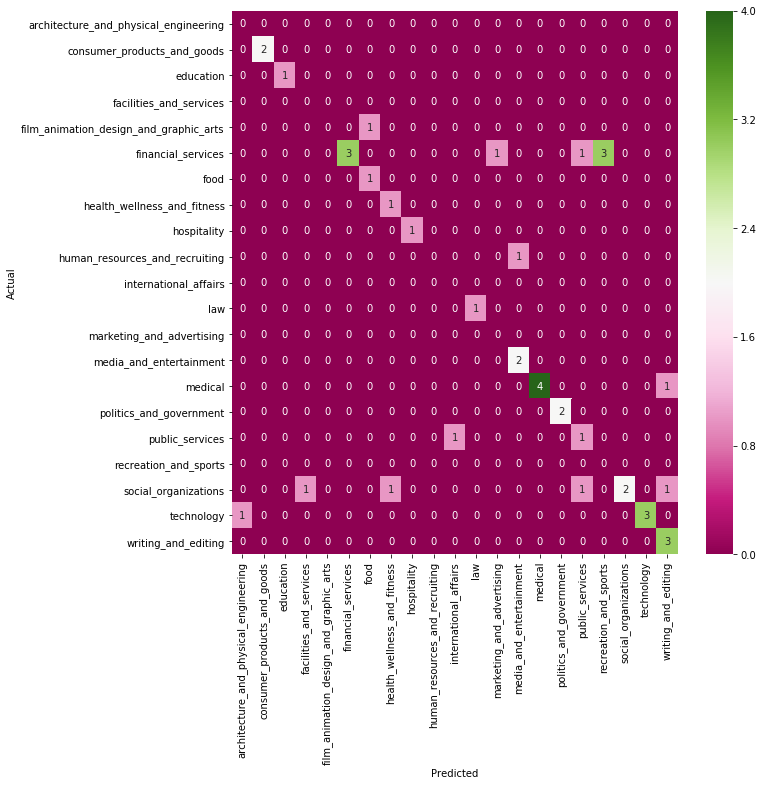

In [16]:
labels = [industry for industry in category_id_df.industry.values if industry in df_comparison["Actual"].unique() or
          industry in df_comparison["Predicted"].unique()]
conf_mat = confusion_matrix(df_comparison["Actual"], df_comparison["Predicted"])
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels, yticklabels=labels, cmap="PiYG")
plt.ylabel('Actual')
plt.xlabel('Predicted')
# plt.xticks(rotation=0)
# plt.yticks(rotation=0)
plt.show()


In [19]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(df_comparison["Actual"],df_comparison["Predicted"])

accuracy

0.7585365853658537